# Typology for doubles

1. Identify 2-artifact clusters (pairs of contiguous artifacts); make sure that the union has no interior
2. For each cluster, classify the inside edge as C or nonC (`drop_interline`: bool)
3. Visualize and test if it works

- number of nodes
- number of continuity groups
- filter non-planarity artifacts
- CES counts
- prime detection
- crosses detection
- touches detecion

In [1]:
import logging

import geopandas as gpd
import matplotlib.pyplot as plt
import momepy
import numpy as np
import pandas as pd
import shapely
from libpysal import graph
from scipy import sparse
import folium
import folium.plugins as plugins
import shapely

from core import algorithms, utils
from core.geometry import voronoi_skeleton, remove_false_nodes

In [2]:
# Get the logger for core.algorithms.simplify
logger = logging.getLogger("core.algorithms.simplify")
logger.setLevel(logging.DEBUG)

# Set the logging format
formatter = logging.Formatter("%(asctime)s - %(name)s - %(levelname)s - %(message)s")

# Create a handler for the logger
handler = logging.StreamHandler()
handler.setLevel(logging.DEBUG)
handler.setFormatter(formatter)

# Add the handler to the logger
logger.addHandler(handler)

Specify case metadata

In [3]:
case = "Liège"

Read road data

In [4]:
roads = utils.read_original(case)

Remove duplicated roads

In [5]:
roads = momepy.remove_false_nodes(roads)
roads = roads[~roads.geometry.duplicated()].reset_index()
roads = momepy.remove_false_nodes(roads)

Identify artifacts

In [6]:
artifacts = momepy.FaceArtifacts(roads).face_artifacts.set_crs(roads.crs)
artifacts["id"] = artifacts.index

Remove edges fully within the artifact (dangles).

In [7]:
a_idx, _ = roads.sindex.query(artifacts.geometry, predicate="contains")
artifacts = artifacts.drop(artifacts.index[a_idx])

Filter doubles

In [8]:
rook = graph.Graph.build_contiguity(artifacts, rook=True)
artifacts["comp"] = rook.component_labels
counts = artifacts["comp"].value_counts()
artifacts = artifacts.loc[artifacts["comp"].isin(counts[counts == 2].index)]

Optionally define a subset of data.

In [18]:
data_sample = artifacts.sort_values("comp").iloc[:60].copy()

In [10]:
def get_type(edges, shared_edge):
    if (  # roundabout special case
        edges.coins_group.nunique() == 1 and edges.shape[0] == edges.coins_count.iloc[0]
    ):
        return "S"

    all_ends = edges[edges.coins_end]
    mains = edges[~edges.coins_group.isin(all_ends.coins_group)]
    shared = edges.loc[shared_edge]
    if shared_edge in mains.index:
        return "C"
    if shared.coins_count == (edges.coins_group == shared.coins_group).sum():
        return "S"
    return "E"


def get_solution(group, roads):
    cluster_geom = group.union_all(method="coverage")

    # find the road segment that is contained within the cluster geometry
    shared = roads.index[roads.sindex.query(cluster_geom, predicate="contains")].item()
    seen_by_a = get_type(
        roads.iloc[roads.sindex.query(group.geometry.iloc[0], predicate="covers")],
        shared,
    )
    seen_by_b = get_type(
        roads.iloc[roads.sindex.query(group.geometry.iloc[1], predicate="covers")],
        shared,
    )
    if seen_by_a == "C":
        return pd.Series({"solution": "iterate", "drop_id": shared})
    if seen_by_a == seen_by_b:
        return pd.Series({"solution": "drop_interline", "drop_id": shared})
    return pd.Series({"solution": "skeleton", "drop_id": shared})

In [11]:
distance = 2

In [27]:
def simplify_pairs(artifacts, roads, distance=2):
    # Get nodes from the network.
    nodes = momepy.nx_to_gdf(momepy.node_degree(momepy.gdf_to_nx(roads)), lines=False)

    # Link nodes to artifacts
    node_idx, artifact_idx = artifacts.sindex.query(
        nodes.buffer(0.1), predicate="intersects"
    )
    intersects = sparse.coo_array(
        ([True] * len(node_idx), (node_idx, artifact_idx)),
        shape=(len(nodes), len(artifacts)),
        dtype=np.bool_,
    )

    # Compute number of nodes per artifact
    artifacts["node_count"] = intersects.sum(axis=0)

    # Compute number of stroke groups per artifact
    roads, _ = algorithms.common.continuity(roads)
    strokes, c_, e_, s_ = algorithms.common.get_stroke_info(artifacts, roads)

    artifacts["stroke_count"] = strokes
    artifacts["C"] = c_
    artifacts["E"] = e_
    artifacts["S"] = s_

    # Filer artifacts caused by non-planar intersections.
    artifacts["non_planar"] = artifacts["stroke_count"] > artifacts["node_count"]
    a_idx, _ = roads.sindex.query(artifacts.geometry.boundary, predicate="overlaps")
    artifacts.loc[artifacts.index[np.unique(a_idx)], "non_planar"] = True

    # Remove (for now) the clusters that contain at least one non-planar component
    # (TODO: we will deal with them later, ...?)
    # non_planar_cluster: number of non-planar artifacts per cluster
    artifacts["non_planar_cluster"] = artifacts.apply(
        lambda x: sum(artifacts.loc[artifacts["comp"] == x.comp]["non_planar"]), axis=1
    )
    # dealing with the non-planar later!
    artifacts = artifacts[artifacts.non_planar_cluster == 0]

    artifacts = artifacts.merge(
        artifacts.groupby("comp").apply(get_solution, roads=roads),
        left_on="comp",
        right_index=True,
    )

    to_drop = (
        artifacts.drop_duplicates("comp").query("solution == 'drop_interline'").drop_id
    )
    merged_pairs = artifacts.query("solution == 'drop_interline'").dissolve(
        "comp", as_index=False
    )

    sorted_by_node_count = artifacts.sort_values("node_count", ascending=False)
    first = sorted_by_node_count.query("solution == 'iterate'").drop_duplicates("comp", keep="first")
    second = sorted_by_node_count.query("solution == 'iterate'").drop_duplicates("comp", keep="last")


    def end_agg(vals):
        return vals.any()


    roads_cleaned = remove_false_nodes(
        roads.drop(to_drop.dropna().values),
        aggfunc={
            "coins_group": "first",
            "coins_end": lambda x: x.any(),
            "coins_count": lambda x: max([x.iloc[0] - 1, 1]),
        },
    )

    loop_1 = algorithms.simplify.simplify_singletons(
        pd.concat([merged_pairs, first]),
        roads_cleaned,
        distance=distance,
        compute_coins=False,
    )
    loop_2 = algorithms.simplify.simplify_singletons(
        second, loop_1, distance=distance, compute_coins=True
    )

    # TODO: include resolving of `solution == 'skeleton'`
    return loop_2

In [28]:
new_roads = simplify_pairs(data_sample, roads)

/var/folders/2f/fhks6w_d0k556plcv3rfmshw0000gn/T/ipykernel_22881/3446732782.py:42: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  artifacts.groupby("comp").apply(get_solution, roads=roads),
2024-07-27 00:44:41,186 - core.algorithms.simplify - DEBUG - FUNCTION nx_gx
2024-07-27 00:44:41,187 - core.algorithms.simplify - DEBUG - HIGHEST C
2024-07-27 00:44:41,194 - core.algorithms.simplify - DEBUG - CONDITION n_comps > 1 True
2024-07-27 00:44:41,197 - core.algorithms.simplify - DEBUG - CONDITION relevant_targets.shape[0] > 0 False, snapping to C
2024-07-27 00:44:41,198 - core.algorithms.simplify - DEBUG - CONDITION remaining_nodes.shape[0] < 2 False
/Users/martin/miniforge3/envs/simplification/lib/pyth

3


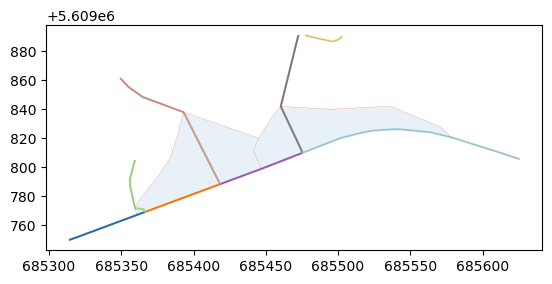

4


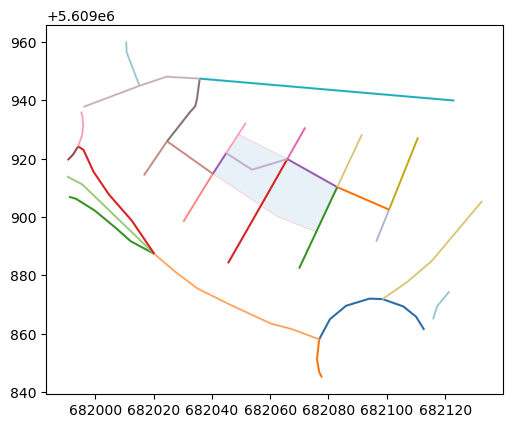

6


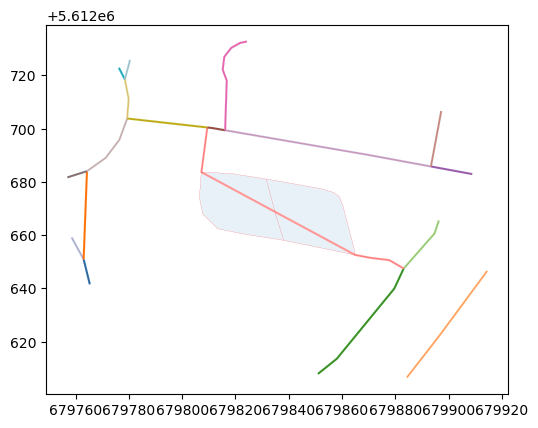

22


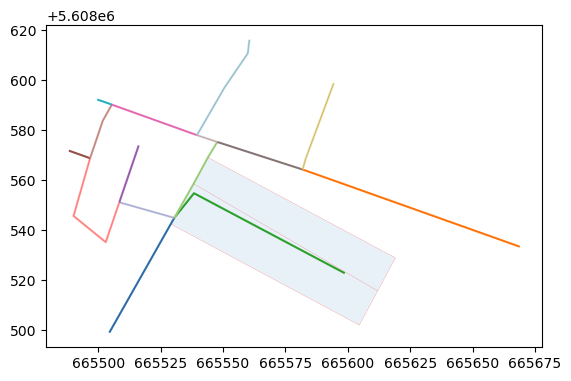

27


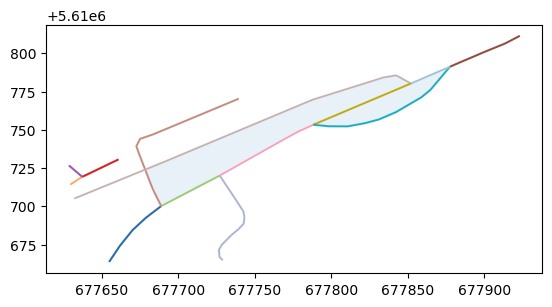

28


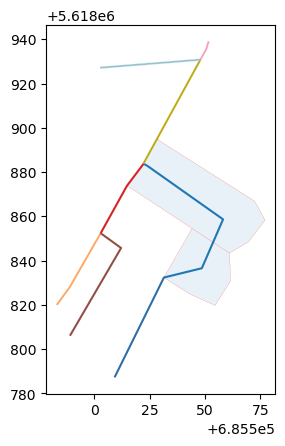

37


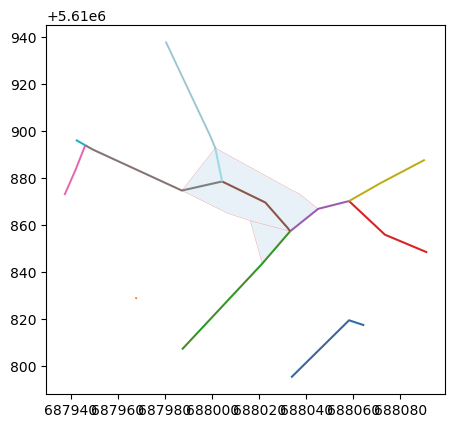

38


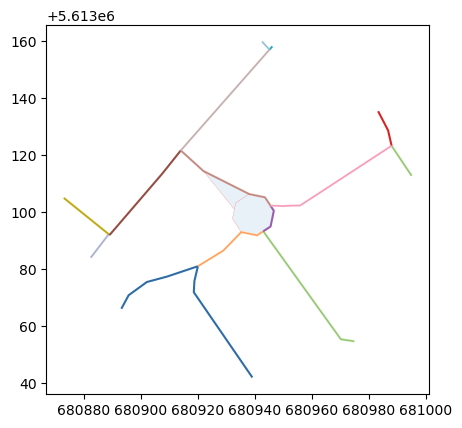

45


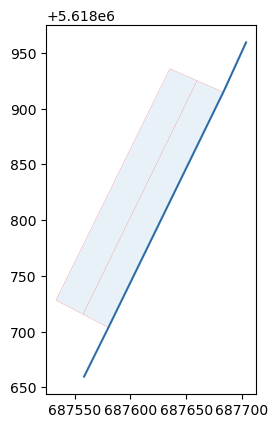

46


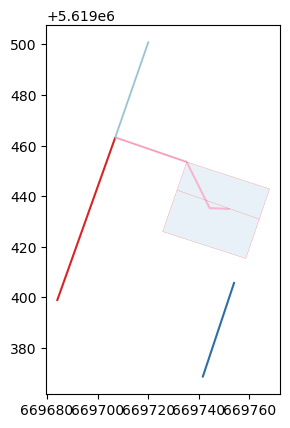

48


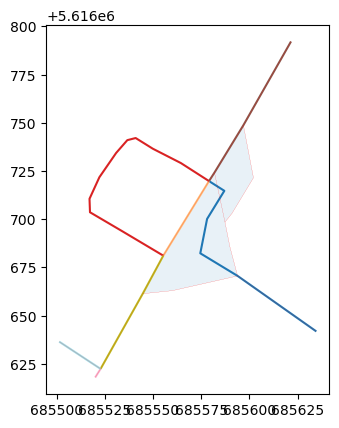

50


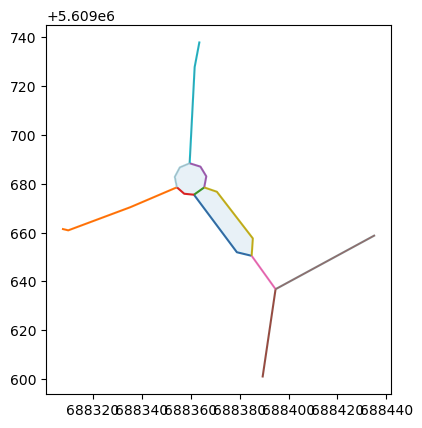

56


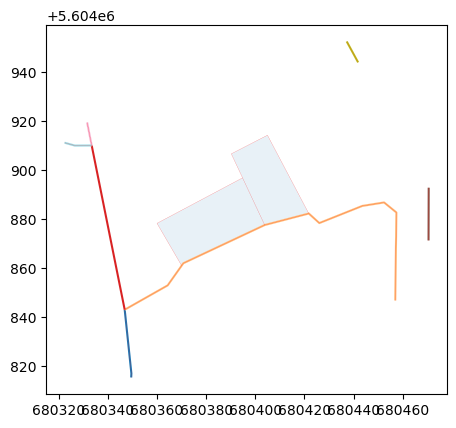

61


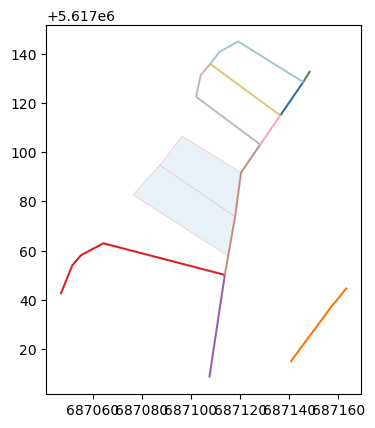

72


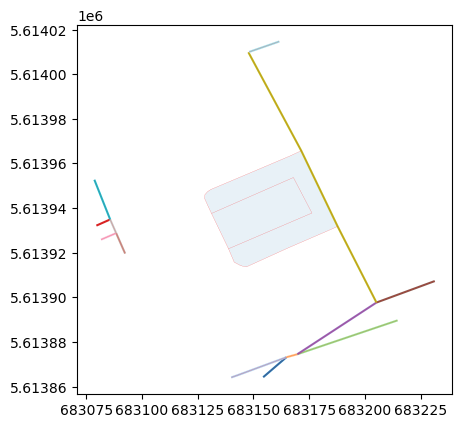

74


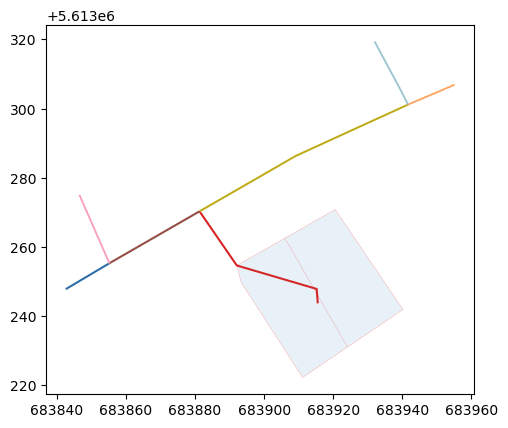

88


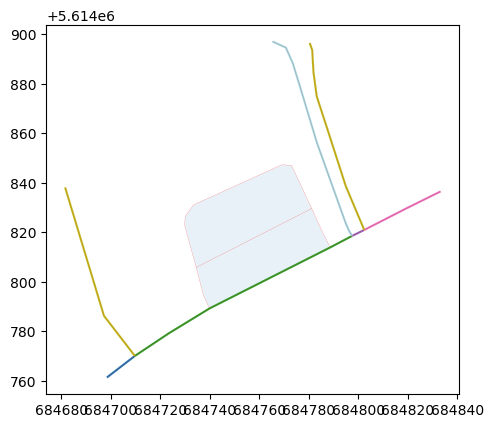

93


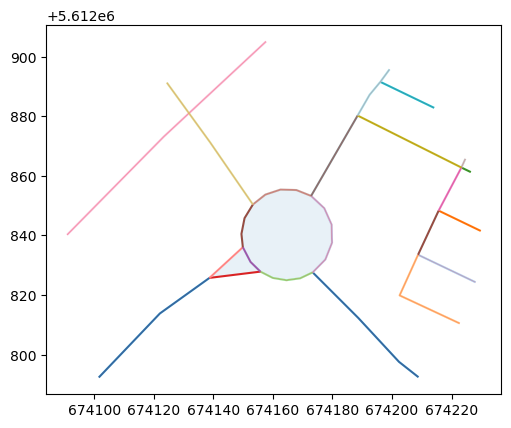

95


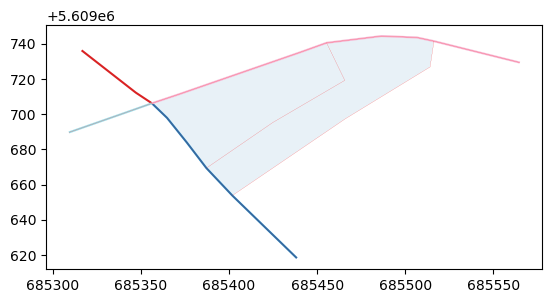

96


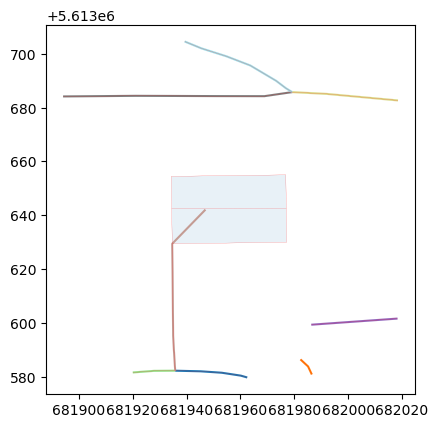

98


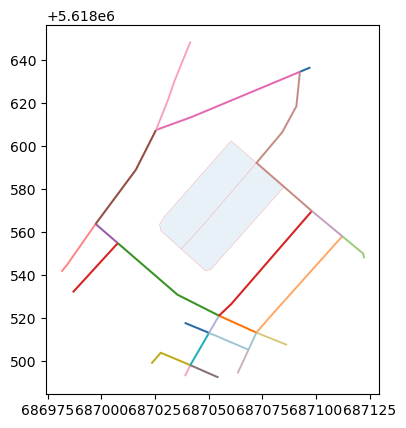

115


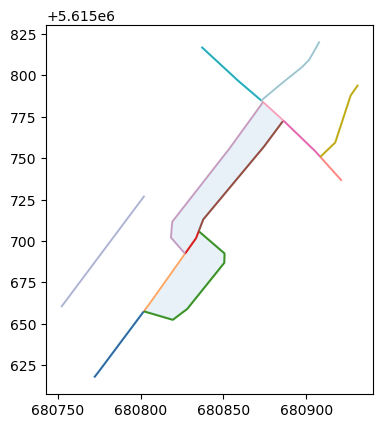

128


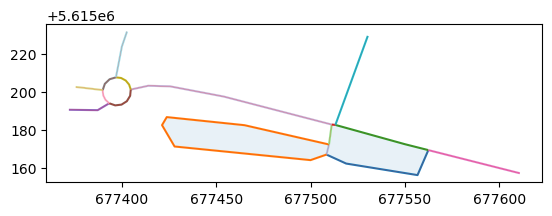

137


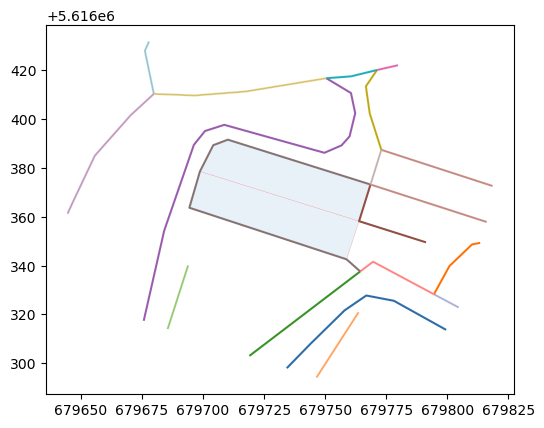

147


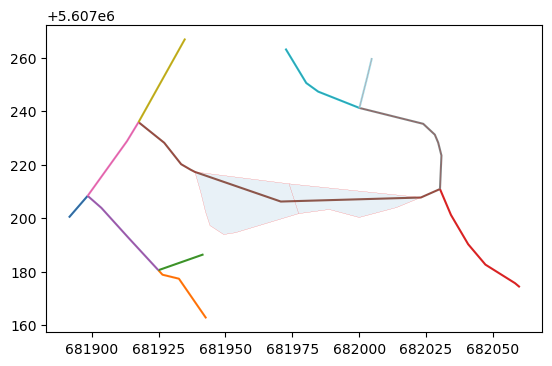

149


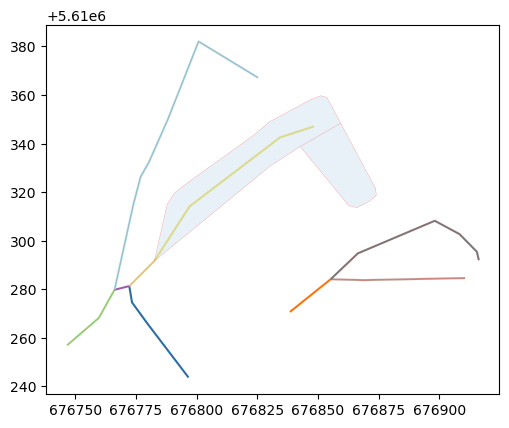

161


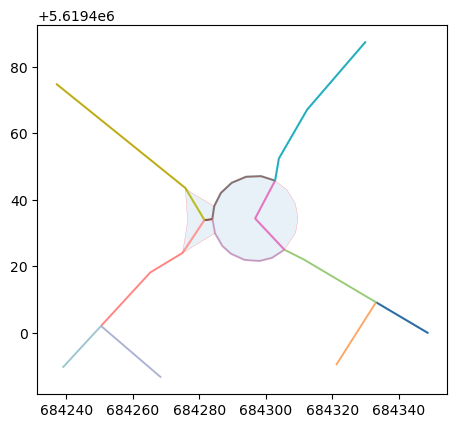

173


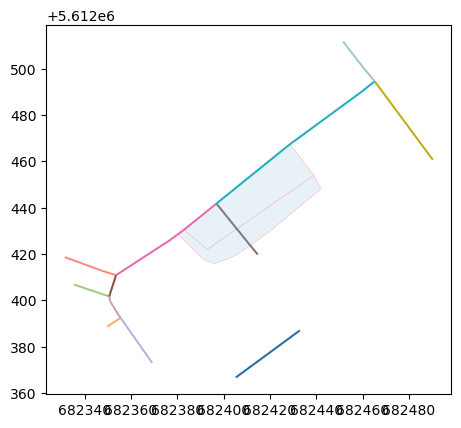

189


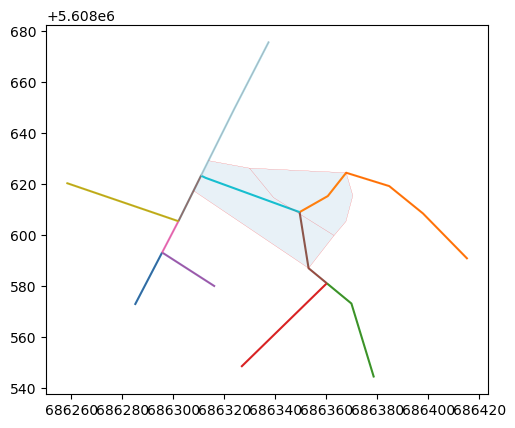

197


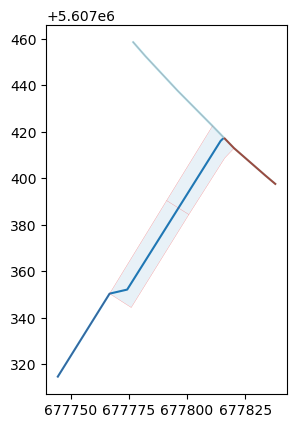

In [29]:
for artifact in data_sample.drop_duplicates("comp").itertuples():
    print(artifact.comp)

    # plot the results for visual verification
    geom = data_sample[data_sample.comp == artifact.comp]
    ax = new_roads.clip(geom.buffer(50)).plot(zorder=2, cmap="tab20")
    geom.plot(ax=ax, alpha=0.1)
    roads.clip(geom.buffer(50)).plot(
        color="red",
        ax=ax,
        # categorical=True,
        # legend=True,
        linewidth=0.1,
    )
    plt.show()

why did the roundabout solution correctly work for: 840, 853, 883? but not all the other examples

<Axes: >

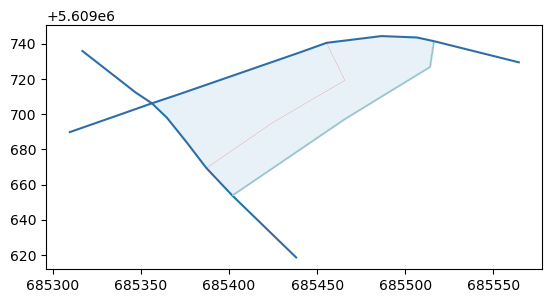

In [20]:
geom = data_sample[data_sample.comp == 95]
ax = roads_cleaned.clip(geom.buffer(50)).plot("coins_end", categorical=True, zorder=2, cmap="tab20")
geom.plot(ax=ax, alpha=0.1)
roads.clip(geom.buffer(50)).plot(
    color="red",
    ax=ax,
    # categorical=True,
    # legend=True,
    linewidth=0.1,
)


In [21]:
roads_cleaned.clip(geom.buffer(50))

,geometry,coins_group,coins_end,coins_count
24405.0,"LINESTRING (685438.485 5609618.179, 685401.836...",487,False,10
257.0,"LINESTRING (685356.168 5609706.111, 685364.74 ...",487,False,10
24420.0,"LINESTRING (685401.836 5609653.728, 685465.976...",9399,True,0
260.0,"LINESTRING (685516.314 5609741.386, 685506.6 5...",658,False,11
24027.0,"LINESTRING (685309.025 5609689.574, 685339.917...",658,False,11
24595.0,"LINESTRING (685565.044 5609729.209, 685564.808...",658,False,11
24156.0,"LINESTRING (685316.255 5609736.172, 685346.993...",487,False,10
